In [1]:
import multiprocessing
import random
from collections import defaultdict, OrderedDict
from pprint import pformat
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from deap import algorithms, base, creator, tools

%matplotlib notebook

## Problem and Solution Definitions

### Class that holds the problem definition.

This class must implements:
* A method to represent the problem graphically (`__str__`)
* A method to generate a problem instance from an input file (`from_file`).

In [2]:
class Problem:
    def __init__(self, rows: int, cols: int, fleet: int, rides: List[List[int]], bonus: int, steps: int):
        self.rows = rows
        self.cols = cols
        self.fleet = fleet
        self.rides = rides
        self.bonus = bonus
        self.steps = steps

    @staticmethod
    def distance(a: int, b: int, x: int, y: int) -> int:
        return abs(x - a) + abs(y - b)
    
    @classmethod
    def ride_length(cls, ride: List[int]) -> int:
        return cls.distance(*ride[0:4])
    
    @classmethod
    def can_reach(cls, x: int, y: int, step: int, ride: List[int]) -> bool:
        return cls.distance(x, y, ride[0], ride[1]) + step <= ride[5] - cls.ride_length(ride)
    
    @property
    def max_bound(self):
        if not hasattr(self, '_max_bound'):
            self._max_bound = len(self.rides) * self.bonus \
                    + np.sum(np.apply_along_axis(lambda x: self.ride_length(x), 1, self.rides[:, 0:4]))
        
        return self._max_bound
    
    @property
    def rides_by_starting(self) -> List[List[int]]:
        return [k for k, ride in sorted(enumerate(self.rides), key=lambda x: x[1][4])]
    
    @classmethod
    def from_file(cls, file_path, *args, **kwargs):
        with open(file_path) as f:
            rows, cols, fleet, num_rides, bonus, steps = [int(i) for i in f.readline().split()]
            rides = np.array([[int(x) for x in line.strip().split()] for i, line in zip(range(num_rides), f.readlines())])

        return cls(rows, cols, fleet, rides, bonus, steps)

    def steps_for_rides(self, rides) -> int:
        x, y = 0, 0
        steps = 0
        for ride in [self.rides[r] for r in rides]:
            steps += max(ride[4], steps + problem.distance(x, y, ride[0], ride[1]))  # Move to ride start point
            steps += problem.ride_length(ride)  # Move to ride end point
            x, y = ride[2:4]
            
        return steps
    
    def is_car_valid(self, rides) -> bool:
        x, y = 0, 0
        step = 0
        for ride_index in rides:
            # Remove ride index
            ride = self.rides[ride_index]

            # Check if ride is valid
            if not self.can_reach(x, y, step, ride):
                return False

            # Update iterative variables
            step += max(ride[4], step + self.distance(x, y, ride[0], ride[1]))  # Move to ride start point
            step += self.ride_length(ride)  # Move to ride end point
            x, y = ride[2:4]

        return True

    def is_individual_valid(self, individual) -> bool:
        rides = [r for i in individual.values() for r in i]
        
        if len(rides) > len(set(rides)):
            return False
        
        for car, rides in individual.items():
            if not self.is_car_valid(rides):
                return False

        return True
    
    def __str__(self):
        return '\n'.join([f'Ride(x={i[0], i[1]}, y={i[2], i[3]}, starting={i[4]}, finish={i[5]})' for i in self.rides])

    def __repr__(self):
        s = f'Problem{{rows={self.rows}, cols={self.cols}, fleet={self.fleet}, bonus={self.bonus}, steps={self.steps}}}'
        if len(self.rides) < 20:
            s += f'\n{str(self)}'
        return s

### Problem instance

In [3]:
#problem = Problem.from_file('input/a_example.in')
problem = Problem.from_file('input/b_should_be_easy.in')
#problem = Problem.from_file('input/c_no_hurry.in')
#problem = Problem.from_file('input/d_metropolis.in')
#problem = Problem.from_file('input/e_high_bonus.in')
problem

Problem{rows=800, cols=1000, fleet=100, bonus=25, steps=25000}

### Class that contains a Solution

The solution to this problem will be represented by a class that can be written and represented, so that following methods must be implemented:
* Serialize the solution into a string (`__str__`).
* Create a string that represents the solution (`__repr__`).
* Write to file the solution (`to_file`).

In [4]:
class Solution:
    """
    A solution for this problem that consists of a structure [[r1, r2, ..., rn]...]
    """
    def __init__(self, data):
        self.data = data

    def to_file(self, file_path):
        with open(file_path, 'w') as f:
            f.write(self.__str__())

    def __str__(self):
        return '\n'.join([' '.join([str(len(rides))] + [str(r) for r in rides]) for rides in self.data.values()])

    def __repr__(self):
        return self.__str__()

## Genetic Algorithm's Operators

In order to generate a population for the Genetic Algorithm it's necessary to define following constants:
* `INDIVIDUAL_TYPE`: The base type for an individual.
* `INDIVIDUAL_SIZE`: Initial size of the individual.

Running the algorithm consists of generating and evaluating individuals, so it's required to define functions for:
* Generating a new individual based on problem instance (`generate`).
* Evaluating the current fitness value of the individual (`evaluate`).

If it's necessary, following functions can be defined:
* Mutate individuals (`mutate`).
* Crossover (`crossover`).

### Helpers

In [5]:
def find_itinerary(car: int, problem: Problem, rides: List[int]) -> List[int]:
    itinerary = []
    step = 0
    x, y = (0, 0)
    try:
        candidates = [i for i in rides if problem.can_reach(x, y, step, problem.rides[i])]
        while len(candidates) and step <= problem.steps:
            # Get a valid ride and remove it from rides pool
            ride_index = random.choice(candidates)
            candidates.remove(ride_index)
            
            # Add ride to itinerary
            itinerary.append(ride_index)
            ride = problem.rides[ride_index]
            
            # Update iterative variables
            x, y = ride[2:4]
            step += max(ride[4], step + problem.distance(x, y, ride[0], ride[1]))  # Move to ride start point
            step += problem.ride_length(ride)  # Move to ride end point
            candidates = [i for i in candidates if problem.can_reach(x, y, step, problem.rides[i])]
    except StopIteration:
        pass
        
    return itinerary

### Constants

In [6]:
INDIVIDUAL_TYPE = dict

### Generation

In [7]:
def generate(problem: Problem) -> Dict[int, List[int]]:
    individual = OrderedDict({})
    rides_completed = []
    rides_available = problem.rides_by_starting
    for c in range(problem.fleet):
        rides_available = [i for i in rides_available if i not in rides_completed]
        rides = find_itinerary(c, problem, rides_available)
        individual[c] = rides
        rides_completed += rides
        
    return creator.Individual(individual)


def generate_population(n: int) -> List:
    pool = multiprocessing.Pool()
    tasks = [pool.apply_async(toolbox.individual) for _ in range(n)]
    return [t.get() for t in tasks]
    

### Evaluation

In [8]:
def evaluate(individual, problem: Problem) -> Tuple[float]:
    if problem.is_individual_valid(individual):
        rides = np.array([problem.rides[r] for car, rides in individual.items() for r in rides])
        distances = np.sum(np.apply_along_axis(problem.ride_length, 1, rides))
        bonus = 0
        return float(distances + bonus),
    else:
        return 0.0,

### Mutation

In [9]:
def mutate(individual, problem) -> Tuple:
    car = random.choice(list(individual.keys()))
    ride_index = random.randint(0, len(individual[car])-1)
    
    if random.random() > 0.5:
        del individual[car][ride_index]
        if len(individual[car]) == ride_index:
            ride_index -= 1
        
    if individual[car]:
        x, y = (0, 0) if ride_index == 0 else problem.rides[individual[car][ride_index]][2:4]
        rides_taken = {i for ride in individual.values() for i in ride}
        rides_available = [r for r in problem.rides_by_starting if r not in rides_taken and problem.can_reach(x, y, 0, problem.rides[r])]

        if rides_available:
            individual[car].insert(ride_index, random.choice(rides_available))
        
    return individual,

### Crossover

In [10]:
def crossover_by_starting(ind1, ind2, problem: Problem) -> Tuple:
    for car in ind1:
        size = min(len(ind1[car]), len(ind2[car]))
        if size > 1:
            cxpoint1 = random.randint(1, size-1)
            ride = problem.rides[ind1[car][cxpoint1]]
            prev_ride = problem.rides[ind1[car][cxpoint1-1]]
            steps = problem.steps_for_rides(ind1[car][:cxpoint1])

            cxpoint2 = None
            for i, r in ((i, r) for i, r in enumerate(ind2[car]) if cxpoint2 is None):
                if problem.can_reach(prev_ride[2], prev_ride[3], steps, problem.rides[r]):
                    cxpoint2 = i

            if cxpoint2:
                ind1[car][cxpoint1:], ind2[car][cxpoint2:] = ind2[car][cxpoint2:], ind1[car][cxpoint1:]
        
    return ind1, ind2

## DEAP toolbox

### Types

In [11]:
creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", INDIVIDUAL_TYPE, fitness=creator.Fitness)

### Population

In [12]:
toolbox = base.Toolbox()
toolbox.register("individual", generate, problem=problem)
toolbox.register("population", generate_population)

### Genetic functions

In [13]:
toolbox.register("evaluate", evaluate, problem=problem)
toolbox.register("mate", crossover_by_starting, problem=problem)
toolbox.register("mutate", mutate, problem=problem)
toolbox.register("select", tools.selNSGA2)

### Multiprocessing

In [14]:
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

## Solution

### Hyperparameters

In [15]:
GENERATIONS = 2000
MU = 10
LAMBDA = 20
CROSSOVER_PROBABILITY = 0.5
MUTATION_PROBABILITY = 0.4

### Run the algorithm

In [16]:
population = toolbox.population(n=MU)

hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# population, log = algorithms.eaSimple(population, toolbox, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, GENERATIONS, stats, halloffame=hof)
population, log = algorithms.eaMuPlusLambda(population, toolbox, MU, LAMBDA, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, GENERATIONS, stats, halloffame=hof)
# population, log = algorithms.eaMuCommaLambda(population, toolbox, MU, LAMBDA, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, GENERATIONS, stats, halloffame=hof)

gen	nevals	avg       	std             	min 	max      
0  	10    	[121159.5]	[40457.70620104]	[0.]	[138327.]
1  	18    	[135577.3]	[1684.54575776] 	[133827.]	[138407.]
2  	17    	[137326.9]	[1288.59671348] 	[134652.]	[138407.]
3  	19    	[138453.3]	[146.72699138]  	[138384.]	[138893.]
4  	17    	[138552.4]	[222.10456997]  	[138407.]	[138893.]
5  	17    	[138960.9]	[283.64394934]  	[138407.]	[139378.]
6  	19    	[139321.7]	[83.40749367]   	[139197.]	[139486.]
7  	18    	[139451.4]	[122.15416489]  	[139378.]	[139788.]
8  	19    	[139687.] 	[287.76135946]  	[139486.]	[140364.]
9  	19    	[139985.7]	[261.27075994]  	[139788.]	[140388.]
10 	16    	[140356.5]	[201.34708838]  	[140014.]	[140845.]
11 	17    	[140521.] 	[203.76064389]  	[140364.]	[140845.]
12 	17    	[140883.3]	[220.04410921]  	[140538.]	[141333.]
13 	20    	[141116.4]	[175.81308256]  	[140845.]	[141333.]
14 	19    	[141500.8]	[310.56490465]  	[141145.]	[142108.]
15 	16    	[141939.] 	[136.08453255]  	[141777.]	[142126.]
16 	19 

140	19    	[156169.] 	[0.]            	[156169.]	[156169.]
141	19    	[156272.8]	[211.63780381]  	[156169.]	[156780.]
142	18    	[156272.8]	[211.63780381]  	[156169.]	[156780.]
143	18    	[156462.] 	[248.48903396]  	[156169.]	[156780.]
144	18    	[156719.5]	[128.92885635]  	[156596.]	[157017.]
145	19    	[156827.4]	[94.8]          	[156780.]	[157017.]
146	16    	[156874.8]	[116.10581381]  	[156780.]	[157017.]
147	19    	[157032.3]	[45.9]          	[157017.]	[157170.]
148	19    	[157047.6]	[61.2]          	[157017.]	[157170.]
149	17    	[157114.5]	[69.74274156]   	[157017.]	[157170.]
150	18    	[157188.9]	[41.35323446]   	[157170.]	[157302.]
151	17    	[157218.7]	[64.7580883]    	[157170.]	[157336.]
152	18    	[157320.7]	[80.36298899]   	[157227.]	[157529.]
153	19    	[157429.8]	[123.54901861]  	[157336.]	[157695.]
154	16    	[157578.8]	[76.07075654]   	[157529.]	[157695.]
155	18    	[157725.5]	[91.5]          	[157695.]	[158000.]
156	19    	[157751.4]	[113.26800078]  	[157695.]	[158000

280	19    	[161577.] 	[0.]            	[161577.]	[161577.]
281	18    	[161577.] 	[0.]            	[161577.]	[161577.]
282	19    	[161588.2]	[33.6]          	[161577.]	[161689.]
283	19    	[161599.4]	[44.8]          	[161577.]	[161689.]
284	17    	[161655.4]	[51.32484778]   	[161577.]	[161689.]
285	17    	[161689.] 	[0.]            	[161689.]	[161689.]
286	19    	[161689.] 	[0.]            	[161689.]	[161689.]
287	19    	[161689.] 	[0.]            	[161689.]	[161689.]
288	18    	[161689.] 	[0.]            	[161689.]	[161689.]
289	19    	[161713.7]	[74.1]          	[161689.]	[161936.]
290	16    	[161738.4]	[98.8]          	[161689.]	[161936.]
291	20    	[161812.5]	[123.5]         	[161689.]	[161936.]
292	18    	[161936.] 	[0.]            	[161936.]	[161936.]
293	19    	[161936.] 	[0.]            	[161936.]	[161936.]
294	20    	[161936.] 	[0.]            	[161936.]	[161936.]
295	18    	[161936.] 	[0.]            	[161936.]	[161936.]
296	20    	[161936.] 	[0.]            	[161936.]	[161936

419	17    	[162499.] 	[0.]            	[162499.]	[162499.]
420	18    	[162499.] 	[0.]            	[162499.]	[162499.]
421	16    	[162499.] 	[0.]            	[162499.]	[162499.]
422	18    	[162499.] 	[0.]            	[162499.]	[162499.]
423	16    	[162499.] 	[0.]            	[162499.]	[162499.]
424	19    	[162502.2]	[9.6]           	[162499.]	[162531.]
425	20    	[162508.6]	[14.66424222]   	[162499.]	[162531.]
426	17    	[162531.] 	[0.]            	[162531.]	[162531.]
427	18    	[162531.] 	[0.]            	[162531.]	[162531.]
428	19    	[162531.] 	[0.]            	[162531.]	[162531.]
429	16    	[162531.] 	[0.]            	[162531.]	[162531.]
430	17    	[162531.] 	[0.]            	[162531.]	[162531.]
431	19    	[162531.] 	[0.]            	[162531.]	[162531.]
432	18    	[162531.] 	[0.]            	[162531.]	[162531.]
433	20    	[162531.] 	[0.]            	[162531.]	[162531.]
434	20    	[162531.] 	[0.]            	[162531.]	[162531.]
435	19    	[162531.] 	[0.]            	[162531.]	[162531

558	18    	[162859.] 	[0.]            	[162859.]	[162859.]
559	18    	[162859.] 	[0.]            	[162859.]	[162859.]
560	18    	[162859.] 	[0.]            	[162859.]	[162859.]
561	14    	[162859.] 	[0.]            	[162859.]	[162859.]
562	18    	[162859.] 	[0.]            	[162859.]	[162859.]
563	18    	[162859.] 	[0.]            	[162859.]	[162859.]
564	18    	[162859.] 	[0.]            	[162859.]	[162859.]
565	15    	[162859.] 	[0.]            	[162859.]	[162859.]
566	18    	[162859.] 	[0.]            	[162859.]	[162859.]
567	19    	[162859.] 	[0.]            	[162859.]	[162859.]
568	19    	[162859.] 	[0.]            	[162859.]	[162859.]
569	16    	[162859.] 	[0.]            	[162859.]	[162859.]
570	20    	[162859.] 	[0.]            	[162859.]	[162859.]
571	18    	[162859.] 	[0.]            	[162859.]	[162859.]
572	20    	[162859.] 	[0.]            	[162859.]	[162859.]
573	18    	[162859.] 	[0.]            	[162859.]	[162859.]
574	16    	[162859.] 	[0.]            	[162859.]	[162859

700	19    	[163264.] 	[0.]            	[163264.]	[163264.]
701	17    	[163264.] 	[0.]            	[163264.]	[163264.]
702	17    	[163264.] 	[0.]            	[163264.]	[163264.]
703	19    	[163264.] 	[0.]            	[163264.]	[163264.]
704	16    	[163264.] 	[0.]            	[163264.]	[163264.]
705	17    	[163264.] 	[0.]            	[163264.]	[163264.]
706	19    	[163264.] 	[0.]            	[163264.]	[163264.]
707	17    	[163264.] 	[0.]            	[163264.]	[163264.]
708	18    	[163264.] 	[0.]            	[163264.]	[163264.]
709	19    	[163264.] 	[0.]            	[163264.]	[163264.]
710	19    	[163264.] 	[0.]            	[163264.]	[163264.]
711	19    	[163264.] 	[0.]            	[163264.]	[163264.]
712	18    	[163264.] 	[0.]            	[163264.]	[163264.]
713	17    	[163264.] 	[0.]            	[163264.]	[163264.]
714	19    	[163264.] 	[0.]            	[163264.]	[163264.]
715	18    	[163264.] 	[0.]            	[163264.]	[163264.]
716	19    	[163264.] 	[0.]            	[163264.]	[163264

842	15    	[163363.] 	[0.]            	[163363.]	[163363.]
843	19    	[163363.] 	[0.]            	[163363.]	[163363.]
844	19    	[163363.] 	[0.]            	[163363.]	[163363.]
845	20    	[163363.] 	[0.]            	[163363.]	[163363.]
846	20    	[163363.] 	[0.]            	[163363.]	[163363.]
847	18    	[163363.] 	[0.]            	[163363.]	[163363.]
848	20    	[163363.] 	[0.]            	[163363.]	[163363.]
849	19    	[163363.] 	[0.]            	[163363.]	[163363.]
850	16    	[163363.] 	[0.]            	[163363.]	[163363.]
851	17    	[163363.] 	[0.]            	[163363.]	[163363.]
852	18    	[163363.] 	[0.]            	[163363.]	[163363.]
853	20    	[163363.] 	[0.]            	[163363.]	[163363.]
854	17    	[163363.] 	[0.]            	[163363.]	[163363.]
855	19    	[163363.] 	[0.]            	[163363.]	[163363.]
856	15    	[163363.] 	[0.]            	[163363.]	[163363.]
857	17    	[163363.] 	[0.]            	[163363.]	[163363.]
858	19    	[163363.] 	[0.]            	[163363.]	[163363

981	19    	[163363.] 	[0.]            	[163363.]	[163363.]
982	18    	[163363.] 	[0.]            	[163363.]	[163363.]
983	18    	[163363.] 	[0.]            	[163363.]	[163363.]
984	19    	[163363.] 	[0.]            	[163363.]	[163363.]
985	17    	[163363.] 	[0.]            	[163363.]	[163363.]
986	15    	[163363.] 	[0.]            	[163363.]	[163363.]
987	20    	[163363.] 	[0.]            	[163363.]	[163363.]
988	18    	[163363.] 	[0.]            	[163363.]	[163363.]
989	18    	[163363.] 	[0.]            	[163363.]	[163363.]
990	20    	[163363.] 	[0.]            	[163363.]	[163363.]
991	16    	[163363.] 	[0.]            	[163363.]	[163363.]
992	19    	[163363.] 	[0.]            	[163363.]	[163363.]
993	18    	[163363.] 	[0.]            	[163363.]	[163363.]
994	17    	[163363.] 	[0.]            	[163363.]	[163363.]
995	17    	[163363.] 	[0.]            	[163363.]	[163363.]
996	19    	[163363.] 	[0.]            	[163363.]	[163363.]
997	19    	[163363.] 	[0.]            	[163363.]	[163363

1118	19    	[163492.] 	[0.]            	[163492.]	[163492.]
1119	17    	[163492.] 	[0.]            	[163492.]	[163492.]
1120	19    	[163492.] 	[0.]            	[163492.]	[163492.]
1121	19    	[163492.] 	[0.]            	[163492.]	[163492.]
1122	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1123	19    	[163492.] 	[0.]            	[163492.]	[163492.]
1124	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1125	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1126	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1127	17    	[163492.] 	[0.]            	[163492.]	[163492.]
1128	17    	[163492.] 	[0.]            	[163492.]	[163492.]
1129	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1130	15    	[163492.] 	[0.]            	[163492.]	[163492.]
1131	15    	[163492.] 	[0.]            	[163492.]	[163492.]
1132	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1133	18    	[163492.] 	[0.]            	[163492.]	[163492.]
1134	19    	[163492.] 	[0.]            	

1256	18    	[163676.] 	[0.]            	[163676.]	[163676.]
1257	15    	[163676.] 	[0.]            	[163676.]	[163676.]
1258	20    	[163676.] 	[0.]            	[163676.]	[163676.]
1259	17    	[163676.] 	[0.]            	[163676.]	[163676.]
1260	14    	[163676.] 	[0.]            	[163676.]	[163676.]
1261	18    	[163676.] 	[0.]            	[163676.]	[163676.]
1262	18    	[163676.] 	[0.]            	[163676.]	[163676.]
1263	18    	[163676.] 	[0.]            	[163676.]	[163676.]
1264	18    	[163676.] 	[0.]            	[163676.]	[163676.]
1265	17    	[163676.] 	[0.]            	[163676.]	[163676.]
1266	16    	[163676.] 	[0.]            	[163676.]	[163676.]
1267	19    	[163676.] 	[0.]            	[163676.]	[163676.]
1268	16    	[163676.] 	[0.]            	[163676.]	[163676.]
1269	19    	[163676.] 	[0.]            	[163676.]	[163676.]
1270	20    	[163676.] 	[0.]            	[163676.]	[163676.]
1271	18    	[163676.] 	[0.]            	[163676.]	[163676.]
1272	18    	[163676.] 	[0.]            	

1396	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1397	15    	[163708.] 	[0.]            	[163708.]	[163708.]
1398	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1399	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1400	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1401	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1402	15    	[163708.] 	[0.]            	[163708.]	[163708.]
1403	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1404	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1405	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1406	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1407	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1408	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1409	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1410	14    	[163708.] 	[0.]            	[163708.]	[163708.]
1411	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1412	20    	[163708.] 	[0.]            	

1535	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1536	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1537	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1538	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1539	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1540	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1541	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1542	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1543	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1544	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1545	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1546	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1547	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1548	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1549	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1550	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1551	18    	[163708.] 	[0.]            	

1672	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1673	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1674	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1675	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1676	15    	[163708.] 	[0.]            	[163708.]	[163708.]
1677	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1678	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1679	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1680	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1681	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1682	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1683	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1684	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1685	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1686	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1687	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1688	18    	[163708.] 	[0.]            	

1810	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1811	14    	[163708.] 	[0.]            	[163708.]	[163708.]
1812	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1813	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1814	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1815	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1816	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1817	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1818	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1819	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1820	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1821	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1822	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1823	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1824	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1825	15    	[163708.] 	[0.]            	[163708.]	[163708.]
1826	19    	[163708.] 	[0.]            	

1947	20    	[163708.] 	[0.]            	[163708.]	[163708.]
1948	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1949	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1950	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1951	15    	[163708.] 	[0.]            	[163708.]	[163708.]
1952	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1953	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1954	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1955	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1956	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1957	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1958	17    	[163708.] 	[0.]            	[163708.]	[163708.]
1959	16    	[163708.] 	[0.]            	[163708.]	[163708.]
1960	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1961	19    	[163708.] 	[0.]            	[163708.]	[163708.]
1962	18    	[163708.] 	[0.]            	[163708.]	[163708.]
1963	16    	[163708.] 	[0.]            	

### Best individual

In [17]:
solution = Solution(data=INDIVIDUAL_TYPE(hof[0]))
print(f'Best individual fitness: {int(hof[0].fitness.wvalues[0])}/{problem.max_bound}')

Best individual fitness: 163708/180798


### Plot evolution

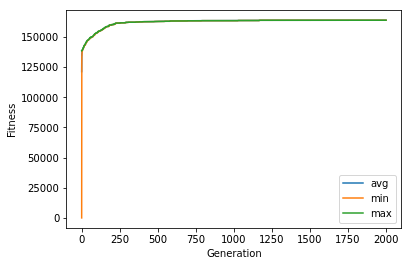

In [18]:
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="avg")
plt.plot(gen, min_, label="min")
plt.plot(gen, max_, label="max")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [19]:
#solution.to_file('output/a.txt')
solution.to_file('output/b.txt')
#solution.to_file('output/c.txt')
#solution.to_file('output/d.txt')
#solution.to_file('output/e.txt')